# *** ⬇⬇⬇⬇⬇⬇⬇ Change the `package` dir with your current dir ⬇⬇⬇⬇⬇⬇⬇ ***

In [3]:
!pip install -q -r requirements.txt

In [4]:
!pip install -q -U sentence-transformers

In [5]:
import sys
import os
import pandas as pd
# import numpy as np
import numpy as np
import cupy as cp
from pathlib import Path
import sys 
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath('..'))

In [32]:
from glob import glob

import os
filtered_files = []
list_of_files = os.listdir('data') #list of files in the current directory
for each_file in list_of_files:
    if each_file.startswith('filtered_ciqcompany'):  #since its all type str you can simply use startswith
        filtered_files.append(each_file)

len(filtered_files)

all_filtered = pd.concat([pd.read_csv(f'data/{f}',error_bad_lines=False,sep='\t') for f in filtered_files],axis=0)
all_filtered= all_filtered.dropna().reset_index(drop=True)

all_filtered.columns, all_filtered.shape

all_filtered = all_filtered.rename(columns={'companyname':'name'}).reset_index(drop=True)



In [33]:
len(filtered_files)

38

In [6]:
matched_frame  = pd.read_csv('data/inferess-sp-ciq-matched-names.tsv', sep='\t')

inferess_comp = pd.read_csv('data/preview-sec-gen-07-set-02-rev-01-2015-2022-company.tsv', sep='\t')

In [7]:
matched_frame

,inferess_entity_id,normalize_name,reference_name,sp_ciq_id,sp_ciq_name
0,70101953912,024 Pharma Inc,"024 Pharma, Inc.",51788819,024 Pharma Inc.
1,70101857119,1-800 Contacts Inc,1-800 Contacts Inc.,378329,"1-800 CONTACTS, INC."
2,70101859206,1-800-FLOWERS.COM Inc,1-800-FLOWERS.COM Inc.,24085,"1-800-FLOWERS.COM, Inc."
3,70101659003,100 and RW CRA LLC,100 & RW CRA LLC,237393026,100 & RW Cra LLC
4,70101699624,10x Genomics Inc,10x Genomics Inc.,223288117,"10x Genomics, Inc."
...,...,...,...,...,...
23680,70101910357,uniQure NV,uniQure N.V.,171029664,uniQure N.V.
23681,70101854751,urban-gro Inc,urban-gro Inc.,431844712,"urban-gro, Inc."
23682,70101576553,vTv Therapeutics Inc,vTv Therapeutics Inc.,304063261,vTv Therapeutics Inc.
23683,70101938898,vitacost.com Inc,vitacost.com Inc.,1057357,"Vitacost.com, Inc."


In [8]:
a = matched_frame[['normalize_name']]
b = matched_frame[['sp_ciq_name']]
c = matched_frame[['reference_name']]


In [9]:
a.isnull().sum(), b.isnull().sum()

(normalize_name    0
 dtype: int64,
 sp_ciq_name    0
 dtype: int64)

In [10]:
a = a.rename(columns={'normalize_name':'name'}).reset_index(drop=True)
b = b.rename(columns={'sp_ciq_name':'name'}).reset_index(drop=True)
c = c.rename(columns={'reference_name':'name'}).reset_index(drop=True)

In [11]:
a = a.astype({"name": str}, errors='raise')
b = b.astype({"name": str}, errors='raise')
c = c.astype({"name": str}, errors='raise')

In [12]:
import neattext as ntx
import re
def preprocess(x):
    x = re.sub(r"[\*\"\n\\…\+\-\/\=\(\)‘•€\[\]\|♫:;—,.”“~`#]", "", x) 

    x = ntx.replace_term(x, ' and ','')
    x = ntx.replace_term(x, '&','')
    x = ntx.replace_term(x, 'aktiengesellschaft','ag')
    x = ntx.replace_term(x, 'public company limited','pcl')
    x = ntx.replace_term(x, 'public limited company','plc')
    x = ntx.replace_term(x, 'limited partnership','lp')
    x = ntx.replace_term(x, 'limited liability company','llc')    
    x = ntx.replace_term(x, 'société anonyme','sa')
    x = ntx.replace_term(x, 'the','')
    x = ntx.replace_term(x, 'private','pvt')    
    x = ntx.replace_term(x, 'limited','ltd')
    x = ntx.replace_term(x, 'company','co')
    x = ntx.replace_term(x, 'incorporated','inc')
    x = ntx.replace_term(x, 'corporation','corp')
    # x = ntx.replace_term(x, ' ','')

    return x 

In [13]:
%%time
load = True

a['norm'] = a['name'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)



b['norm'] = b['name'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

c['norm'] = c['name'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)


# if load:
#     all_filtered = pd.read_csv('data/all_filtered_normalized.tsv', sep='\t')
# else:
    
#     all_filtered['norm'] = all_filtered['name'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
#         .apply(lambda x : x.lower()).apply(preprocess)
        
            
        
        


CPU times: user 816 ms, sys: 2 ms, total: 818 ms
Wall time: 824 ms


In [34]:
all_filtered.shape

(10314918, 2)

In [14]:
a['norm_ws'] = a['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 
b['norm_ws'] = b['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 
c['norm_ws'] = c['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 

# all_filtered['norm_ws'] = all_filtered['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 

In [13]:
# all_filtered.to_csv('data/all_filtered_normalized.tsv', sep='\t')


In [14]:
a['f_word'] = a.norm.apply(lambda x : ''.join(x.split()[:-1]) if len(x.split()) > 1 else ''.join(x.split())).apply(lambda x : ntx.replace_term(x, ' ',''))
b['f_word'] = b.norm.apply(lambda x : ''.join(x.split()[:-1]) if len(x.split()) > 1 else ''.join(x.split())).apply(lambda x : ntx.replace_term(x, ' ',''))


In [10]:
import faiss
assert hasattr(faiss, "IndexFlatIP")
use_faiss = True 

In [15]:
import torch 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [ ]:

sentences_or_file_path = a['name'].tolist()
index = {"sentences": sentences_or_file_path}

if use_faiss:
    quantizer = faiss.IndexFlatIP(embeddings.shape[1])  
    if True:
        index = faiss.IndexIVFFlat(quantizer, embeddings.shape[1], min(self.num_cells, len(sentences_or_file_path)), faiss.METRIC_INNER_PRODUCT) 
    else:
        index = quantizer

    if (device == "cuda" and device != "cpu") or device == "cuda":
        if hasattr(faiss, "StandardGpuResources"):
            logger.info("Use GPU-version faiss")
            res = faiss.StandardGpuResources()
            res.setTempMemory(20 * 1024 * 1024 * 1024)
            index = faiss.index_cpu_to_gpu(res, 0, index)
        else:
            logger.info("Use CPU-version faiss")


In [ ]:
match_ngrams = matcher._vec.transform(
    to_be_matched[matcher._column_matching].tolist()).tocsc()
results = sparse_cosine_top_n(
    matrix_a=matcher._n_grams_matching, matrix_b=match_ngrams, top_n=matcher._top_n, low_memory=matcher._low_memory, number_of_rows=matcher._number_of_rows, verbose=matcher._verbose)


# Create dataset for Entity Linking

Train a neural network to encode enities into dense dimension represent the charaters that match two entities# Create an dataset fot entity linking 

1. Collect positive links: 
`Collect highly scored names with the rule based methods that guarantee correctness of the matching`
---
2. Collect hard negative links:
`Hard negative matches means pretty close but not match to distinguish the distinct point that match between two names`
---
3. Symbol and what it stand for: 
`This hopefully will allow the neural networt to understand if some words can match it's intials`
---
4. Leverage the SME knowledge base to create some fake examples: 
`Searching for hard patterns like:`
- two words have no space between them
- some symbols used as short cut
- create fake shortcuts and real one as pos and neg samples



In [18]:
from Levenshtein import distance, ratio


In [19]:

%%time
from tqdm import tqdm
d = a
similarities = np.zeros((d.shape[0], d.shape[0]))

for i in tqdm(range(4314,len(d))):
    for j in range(len(d)):
        similarities[i][j] = ratio(a.iloc[i]['norm'], b.iloc[j]['norm'] )


 56%|█████▌    | 10788/19371 [4:51:08<3:51:37,  1.62s/it]


KeyboardInterrupt: 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3255814 , 0.4       , 0.35294118, ..., 0.43478261, 0.36363636,
        0.25      ],
       [0.25      , 0.34042553, 0.33333333, ..., 0.3255814 , 0.43902439,
        0.27027027],
       ...,
       [0.35294118, 0.29268293, 0.28571429, ..., 0.32432432, 0.4       ,
        0.25806452],
       [0.17391304, 0.33333333, 0.19354839, ..., 0.30769231, 0.41666667,
        0.4       ],
       [0.28571429, 0.47619048, 0.37209302, ..., 0.57894737, 0.61111111,
        0.3125    ]])

In [24]:
np.save("data/sim2.npy", similarities[4314:15102])

In [20]:
neg_dict = {'word':[], 'neg':[]} 
for i,sim in enumerate(similarities):
    sorted = np.argsort(sim,axis=0)
    top_sim = sorted[::-1][1:20]
    top_sim = top_sim[np.where(sim[top_sim] >= 0.7)]
    word = a.iloc[i]['name']
    sim_neg = b.iloc[top_sim]['name'].tolist() 
    neg_dict['word'] += [word]*len(sim_neg)

    neg_dict['neg'] += sim_neg



pd.DataFrame(neg_dict).to_json('data/neg_names.json')

NameError: name 'similarities' is not defined

In [21]:
neg_name = pd.read_json('data/neg_names.json')

In [31]:
neg_name['norm'] = neg_name['word'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['norm_ws'] = neg_name['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 

neg_name['neg_norm'] = neg_name['neg'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['neg_norm_ws'] = neg_name['neg_norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 


In [32]:

positives = list(zip(a.norm_ws.tolist(),b.norm_ws.tolist()))
negatives = list(zip(neg_name.norm_ws.tolist(),neg_name.neg_norm_ws.tolist() ) )


X_train = positives + negatives
y_train = [1]*len(positives) + [0]*len(negatives)

assert len(X_train) == len(y_train)

pd.DataFrame({"X_train":X_train,'y_train':y_train} ).to_json('data/training_data_v1.json')



In [37]:
shuffle = True 
train_data = pd.read_json('data/training_data_v1.json')
if shuffle: 
    train_data = train_data.sample(frac=1)

In [37]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

train_data.sample(20)

,X_train,y_train
35031,"[alleteinc, atexinc]",0
33542,"[airgasinc, arazuinc]",0
3712,"[cedromsniinc, cedromsniinc]",1
21695,"[upmcchildren'shospitalofpittsburgh, upmcchildren'shospitalofpittsburgh]",1
53328,"[bitzioinc, itroninc]",0
18194,"[sdc, sdc]",1
12760,"[mddsrl, mddsrl]",1
38964,"[amrepcorp, arielcorp]",0
6812,"[essabancorpinc, essabancorpinc]",1
11539,"[kochenergyservicesllc, kochenergyservicesllc]",1


# Sentence Encoder

In [16]:
from sentence_transformers import SentenceTransformer
# model_name = 'sentence-transformers/paraphrase-albert-small-v2'
model_name = 'paraphrase-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']


#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [19]:
model.__dict__.keys()

dict_keys(['_model_card_vars', '_model_card_text', '_model_config', 'training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', '_target_device'])

In [53]:
# Examine Tokenizer

In [49]:
 %%time
word_embeddings_a = model.encode(a.name)
word_embeddings_b = model.encode(b.name)

CPU times: user 13.7 s, sys: 1.72 s, total: 15.5 s
Wall time: 12.3 s


In [ ]:
word_embeddings_a.shape

In [46]:
%%time
word_embeddings_all = model.encode(all_filtered.head(500_000)['name'],batch_size=264,device='cuda',normalize_embeddings=True)

CPU times: user 54.4 s, sys: 11.5 s, total: 1min 5s
Wall time: 49.2 s


In [44]:
model.encode?

Signature:
model.encode(
    sentences: Union[str, List[str]],
    batch_size: int = 32,
    show_progress_bar: bool = None,
    output_value: str = 'sentence_embedding',
    convert_to_numpy: bool = True,
    convert_to_tensor: bool = False,
    device: str = None,
    normalize_embeddings: bool = False,
) -> Union[List[torch.Tensor], numpy.ndarray, torch.Tensor]
Docstring:
Computes sentence embeddings

:param sentences: the sentences to embed
:param batch_size: the batch size used for the computation
:param show_progress_bar: Output a progress bar when encode sentences
:param output_value:  Default sentence_embedding, to get sentence embeddings. Can be set to token_embeddings to get wordpiece token embeddings. Set to None, to get all output values
:param convert_to_numpy: If true, the output is a list of numpy vectors. Else, it is a list of pytorch tensors.
:param convert_to_tensor: If true, you get one large tensor as return. Overwrites any setting from convert_to_numpy
:param devic

In [41]:
np.save('data/text.npy',word_embeddings_all)

In [50]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [51]:
s  = pairwise_cosine_similarity(torch.tensor(word_embeddings_a),torch.tensor(word_embeddings_b)).numpy()

In [60]:
%%time
sorted_mat = cp.argsort(cp.array(s), axis=1)

OutOfMemoryError: Out of memory allocating 13,467,884,544 bytes (allocated so far: 13,463,502,848 bytes).

Exception ignored in: 'cupy.cuda.thrust.cupy_malloc'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 742, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1419, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1440, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1120, in cupy.cuda.memory.SingleDeviceMemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1141, in cupy.cuda.memory.SingleDeviceMemoryPool._malloc
  File "cupy/cuda/memory.pyx", line 1379, in cupy.cuda.memory.SingleDeviceMemoryPool._try_malloc
cupy.cuda.memory.OutOfMemoryError: Out of memory allocating 13,467,884,544 bytes (allocated so far: 13,463,502,848 bytes).


CPU times: user 890 ms, sys: 2.29 s, total: 3.18 s
Wall time: 3.44 s


In [61]:
sorted_mat

array([[    0,     1,     2, ..., 23682, 23683, 23684],
       [    0,     1,     2, ..., 23682, 23683, 23684],
       [    0,     1,     2, ..., 23682, 23683, 23684],
       ...,
       [    0,     1,     2, ..., 23682, 23683, 23684],
       [    0,     1,     2, ..., 23682, 23683, 23684],
       [    0,     1,     2, ..., 23682, 23683, 23684]])

In [52]:
from tqdm import tqdm
correct = 0
mistakes = []
for i in tqdm(range(len(a))): 
    sim = s[i]
    sorted_data = cp.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:5]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist()})
        
    

100%|██████████| 23685/23685 [00:45<00:00, 521.36it/s]


In [54]:
correct / len(a), len(a)-correct

(0.9883048342833016, 277)

In [55]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes).sample(50)

,a_name,b_name,sim
143,JPA,J P A,"[Npa, PLS CPA, FPA, APA Corporation, Se.Pa. S.R.L.]"
23,ATJ Corp,A.T.J. Corporation,"[ATS Corporation, AT&T Corp., AT&T Inc., Atkore Inc., Atex, Inc.]"
59,CTO PCL,C.T.O. Public Company Limited,"[PCB Bancorp, PCB SA, PCT Ltd, PCSB Financial Corporation, HPA]"
185,One SA,ONE S.A.,"[N.B.G. SA, S.N.F. SA, ONE, M.R. SA, Elis SA]"
242,SFA SA,S.F.A. S.A.,"[Agfa Corporation, MFA Financial, Inc., SGS SA, MFA Incorporated, Fa Corp]"
270,V Ships Ltd,V.Ships Limited,"[Capital Ship Management Corp., Nautique Boat Company, Inc., MasterCraft Boat Holdings, Inc., Boatsforsale.com, Union Maritime Limited]"
170,MS Zinc,"MSZ, Inc.","[Korea Zinc Company, Ltd., Solitario Zinc Corp., Centrotrade Minerals & Metals Inc., Commercial Metals Company, ZTE Corporation]"
12,AGLC,A.G.L.C,"[Dlc, LCT, PLLC, LCM GmbH, Hplc B.V.]"
138,Infinity NV,Infinity N.V.,"[NV, Infinity a.s., Infinity, Fagron NV, NVM]"
228,RTA SRL,R.T.A. S.R.L.,"[SCC Srl, Mosa Srl, Z.F. Srl, Pos Srl, Rala Srl]"


In [27]:
%%time
import chars2vec
import torch
path_to_model = 'artifacts'
# Load pretrained model, create word embeddings
c2v_model = chars2vec.load_model(path_to_model)


CPU times: user 895 ms, sys: 23.2 ms, total: 918 ms
Wall time: 955 ms


In [ ]:
filtered_emb = c2v_model.vectorize(all_filtered.norm_ws.head(1000_000).tolist())

In [40]:
%%time
words = ['good ok', 'goodness okay', 'god well']

# Create word embeddings
word_embeddings_a = c2v_model.vectorize(a.norm_ws.tolist())
word_embeddings_b = c2v_model.vectorize(b.norm_ws.tolist())


741/741 [==============================] - 3s 4ms/step
CPU times: user 8.52 s, sys: 1.39 s, total: 9.91 s
Wall time: 8.59 s


In [41]:
from torchmetrics.functional import pairwise_cosine_similarity

In [42]:
s  = pairwise_cosine_similarity(torch.tensor(word_embeddings_a),torch.tensor(word_embeddings_b)).numpy()

In [43]:
from tqdm import tqdm
correct = 0
mistakes = []
for i in tqdm(range(len(a))): 
    sim = s[i]
    sorted_data = np.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:5]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist()})
        
    

100%|██████████| 23685/23685 [00:41<00:00, 566.15it/s]


In [45]:
correct / len(a), len(a)-correct

(0.9913869537682077, 204)

In [46]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes).sample(50)

,a_name,b_name,sim
145,Redpag Electronicos S.A.P.I. de CV,Redpag Electrónicos S.A.P.I. de C.V,"[Texla Energy Management, Inc., Relief Therapeutics Holding AG, Red Bluff Resources Operating, LLC, Emergent Capital, Inc., MarkWest Energy Partners, L.P.]"
89,KeyBank NA,KeyBank National Association,"[Mindshare, Hubbell Incorporated, México Transportes Aéreos, S. A. De C. V, Human Capital Management Limited, Helium AB]"
88,Kauai Island Utility Coop,Kauai Island Utility Cooperative,"[Megalith Financial Acquisition Corp., Oldcastle Precast, Inc., Marina District Finance Company, Inc., MBT Financial Corp., Kaiser Aluminum Corporation]"
37,Children's Learnings Adventure USA LLC,"Children's Learning Adventure USA, LLC","[Complete Business Solutions Group, Inc., Cook Inlet Natural Gas Storage Alaska LLC, Behringer Harvard Multifamily Management Services, LLC, Brookhaven Science Associates LLC, Covenant Logistics Group, Inc.]"
114,NORTHERN STATES POWER Co,Northern States Power Company,"[Norton Rose Fulbright LLP, Nortridge Software, LLC, Northwest Pipe Company, Fonterra Co-operative Group Limited, Kontoor Brands, Inc.]"
128,Orexo AB,Orexo AB (publ),"[O'reilly, Umpqua Bank, Euromedica S.A., Topas AB, Roan B.V.]"
30,CREDIT AGRICOLE SECURITIES (USA) Inc,Crédit Agricole Securities (USA) Inc.,"[Credit Market Analysis Limited, CyDex Pharmaceuticals, Inc., CVR Energy, Inc., Credex Corporation, Xcel Energy Inc.]"
29,CREDIT AGRICOLE CORPORATE AND INVESTMENT BANK,Crédit Agricole Corporate And Investment Bank,"[Credit One Financial, Inc., Crown Food Service Equipment Ltd., Crowe Horwath International, BNY Mellon Trust of Delaware, Creative Solutions In Healthcare, Inc.]"
159,Santander Bank NA,"Santander Bank, National Association","[Standard Chartered Bank Kenya Limited, Seaniemac International, Ltd., Saudi Arabian National Guard, Lucid Energy Delaware, LLC, Sailun (Vietnam) Co., Ltd.]"
0,ABE Ltd,A.B.E. LIMITED,"[Able N.V., AltheaDx, Inc., B & A Limited, Beam, Inc., AAI Limited]"


1/1 [==============================] - 1s 739ms/step


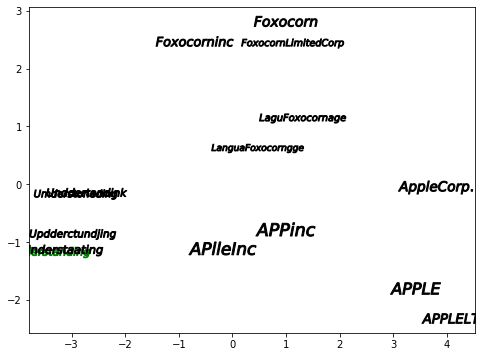

In [79]:
import sklearn.decomposition
import matplotlib.pyplot as plt


words = ['APlle Inc', 'Foxocorn Limited Corp', 'Understanding',
         'Apple Corp.', 'Foxocorn inc', 'Updderctundjing',
         'APPLE', 'Foxocorn', 'Understaating',
         'APP inc', 'LaguFoxocornage', 'Unddertandink',
         'APPLE LTD', 'LanguaFoxocorngge', 'Umderstoneding']

# Create word embeddings
word_embeddings = c2v_model.vectorize_words(words)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(word_embeddings)

# Draw words on plane
f = plt.figure(figsize=(8, 6))

for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
                marker=('$' + words[j] + '$'),
                s=500 * len(words[j]), label=j,
                facecolors='green' if words[j]
                            in ['Natural', 'Language', 'Understanding'] else 'black')

plt.show()

In [41]:
i = 1
sim = s[i].numpy()
sorted_data = np.argsort(sim,axis=0)
top_sim = sorted_data[::-1][1:20]


In [42]:
sim[top_sim]

array([0.9998301 , 0.9997969 , 0.9997716 , 0.9997145 , 0.99970466,
       0.9996715 , 0.99966264, 0.9996414 , 0.9996224 , 0.9996041 ,
       0.9995898 , 0.9995534 , 0.9995492 , 0.9995331 , 0.99951977,
       0.9995184 , 0.9995045 , 0.9994996 , 0.9994714 ], dtype=float32)

In [43]:
a.iloc[i]['name']

'1-800 Contacts Inc'

In [44]:
b.iloc[i]['name']

'1-800 CONTACTS, INC.'

In [45]:
from scipy import spatial
def calc_sim(model,sent1,sent2):
    word1 = model.vectorize([sent1])
    wrod2 = model.vectorize([sent2])
    result = 1 - spatial.distance.cosine(word1, wrod2)
    return result
    
    
    
    

In [49]:
calc_sim(c2v_model, a.iloc[i]['name'], b.iloc[i]['name'])

1/1 [==============================] - 0s 16ms/step


0.9858397841453552

False

In [81]:
# sanity check for embeddings
from scipy import spatial
from tqdm.auto import tqdm 
similarities = []
for i in tqdm(range(len(a))) : 
    distance  = 1 - spatial.distance.cosine(word_embeddings_a[i], word_embeddings_b[i])

    similarities.append({'a_norm':a.iloc[i]['name'],'b_norm':b.iloc[i]['name'], 'distance':distance})

sim = pd.DataFrame(similarities)
pd.set_option('display.max_rows', 100)

sim[sim['distance'] < 0.5].shape

  0%|          | 0/23685 [00:00<?, ?it/s]

(6, 3)

In [24]:
import faiss
assert hasattr(faiss, "IndexFlatIP")
use_faiss = True 

import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

sentences_or_file_path = a['name'].tolist() 
c_index = {"sentences": sentences_or_file_path}
num_cells_in_search = 10 
num_cells = 100
faiss_fast  = True 
use_faiss = True
if True:
    quantizer = faiss.IndexFlatIP(word_embeddings_a.shape[1])  
    if True:
        index = faiss.IndexIVFFlat(quantizer, word_embeddings_a.shape[1], min(num_cells, len(sentences_or_file_path)), faiss.METRIC_INNER_PRODUCT) 
    else:
        index = quantizer

    if (device == "cuda" and device != "cpu") or device == "cuda":
        if hasattr(faiss, "StandardGpuResources"):
            res = faiss.StandardGpuResources()
            res.setTempMemory(20 * 1024 * 1024 * 1024)
            index = faiss.index_cpu_to_gpu(res, 0, index)



if faiss_fast:            
    index.train(word_embeddings_a.astype(np.float32))
index.add(word_embeddings_a.astype(np.float32))
index.nprobe = min(num_cells_in_search, len(sentences_or_file_path))
is_faiss_index = True
c_index["index"] = index

## Search 

queries = b.name.tolist() 
query_vecs = word_embeddings_b
distance, idx = c_index["index"].search(query_vecs.astype(np.float32), 20)
def pack_single_result(dist, idx):
    results = [(c_index["sentences"][i], s) for i, s in zip(idx, dist) if s >= 0.0]
    return results

if isinstance(queries, list):
    combined_results = []
    for i in range(len(queries)):
        results = pack_single_result(distance[i], idx[i])
        combined_results.append(results)


i = 4
combined_results[i], a.name[i]

ModuleNotFoundError: No module named 'faiss'

# Attention for Company names embeddings 

In [82]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [103]:
encoded  = tokenizer.tokenize('corp')
encoded

['corp']

In [104]:
encoded

['corp']

In [140]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.7 MB/s eta 0:00:0000:0100:01


In [88]:
from simcse.core import SimCSE
if True: 
    sim_pretrained= "princeton-nlp/sup-simcse-roberta-base"
    simcse_model = SimCSE(sim_pretrained )

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [15]:
simcse_model.build_index(b.norm.tolist())

12/10/2022 19:00:16 - INFO - faiss.loader -   Loading faiss with AVX2 support.
12/10/2022 19:00:16 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
12/10/2022 19:00:16 - INFO - faiss.loader -   Loading faiss.
12/10/2022 19:00:16 - INFO - faiss.loader -   Successfully loaded faiss.
12/10/2022 19:00:16 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 371/371 [00:18<00:00, 20.48it/s]
12/10/2022 19:00:35 - INFO - simcse.core -   Building index...
12/10/2022 19:00:35 - INFO - simcse.core -   Use GPU-version faiss
12/10/2022 19:00:36 - INFO - simcse.core -   Finished


In [175]:
%%time
from random import randint

i = randint(0, len(a))

sent1 = a.iloc[i]['name']
sent2 = b.iloc[i]['name']

simcse_model.tokenizer.tokenize(sent1),\
simcse_model.tokenizer.tokenize(sent2),\
sent1,\
sent2,\
simcse_model.tokenizer.batch_encode_plus([sent1,sent2])

CPU times: user 2.37 ms, sys: 272 µs, total: 2.65 ms
Wall time: 1.69 ms


(['LE', 'G', 'END', 'ĠPRODUCT', 'ION', 'ĠH', 'OLD', 'INGS', 'ĠLLC'],
 ['Legend', 'ĠProduction', 'ĠHoldings', ',', 'ĠLLC'],
 'LEGEND PRODUCTION HOLDINGS LLC',
 'Legend Production Holdings, LLC',
 {'input_ids': [[0, 3850, 534, 9309, 38948, 7744, 289, 20245, 10942, 2291, 2], [0, 46530, 9850, 4357, 6, 2291, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]})

In [113]:
encoded = simcse_model.encode(a.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:09<00:00, 39.01it/s]


In [114]:
encoded_b = simcse_model.encode(b.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:09<00:00, 38.11it/s]


In [115]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [116]:
# C = torch.einsum('id,jd->ij', torch.tensor(word_embeddings_a),torch.tensor(word_embeddings_b)).numpy()
simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()

/tmp/ipykernel_851/1793419373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()


In [122]:
from tqdm import tqdm
correct = 0
for i in tqdm(range(len(a))): 
    sim = simcse_emb_sim[i]
    sorted_data = np.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:10]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist(),'scores':sim[top_sim]})

100%|██████████| 23685/23685 [00:43<00:00, 549.22it/s]


In [127]:
sim[top_sim]

array([1.0000002 , 0.73694193, 0.72461444, 0.7137827 , 0.7051592 ,
       0.69249487, 0.69236547, 0.69117194, 0.6852501 , 0.68323505],
      dtype=float32)

In [124]:
correct/len(a), correct

(0.9966223348110619, 23605)

In [125]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes).sample(50)

,a_name,b_name,sim,scores
3184,HOUSTON REFINING LP,Houston Refining LP,"[GREEN HOUSE CO., LTD., LANXESS Aktiengesellschaft, DENTSPLY SIRONA Inc., PGA TOUR, Inc, GLOBALFOUNDRIES Inc., SSTL, Inc., U.S. LUMBER GROUP, LLC, Agbri Fannin, L.p, LANXESS Inc., A T G, Inc]",NaN
1068,GUARDIAN PENSION TRUSTEES Ltd,Guardian Pension Trustees Ltd,"[Peoples Ltd., Pilatus Ltd., TWD Industrial Co. Ltd., UST Co., Ltd., Trafigura Pte - Ltd]",NaN
12,ALUMINA ESPANOLA SA,"Alúmina Española, S.A.","[Pay-Per-View, Sherpa GMBH, Golden Hills Wind, LLC, ARK Diagnostics, Inc., Deep Well Oil & Gas, Inc.]",NaN
3468,MARLEX PHARMACEUTICALS Inc,"Marlex Pharmaceuticals, Inc.","[TELCON RF PHARMACEUTICAL. Inc., THE PHARM, LLC, AJINOMOTO PHARMACEUTICALS Co., Ltd., BMR-AXIOM LP, CPaiR, Inc, JMHLS LLC, MZHCI, LLC, LANXESS Inc., H Company IP, LLC, BIOMET 3i LLC]",NaN
3368,Katayama Chemical Industries Co Ltd,"KATAYAMA CHEMICAL INDUSTRIES Co., Ltd.","[Toyama Chemical Co., Ltd., Tata Chemicals Limited, Sumitomo Chemical Company, Limited, Mitsubishi Chemical Corporation, Nikko Chemicals Co., Ltd., Kawasaki Heavy Industries, Ltd., Toyota Industries Corporation, Shandong Morui Chemical Co., Ltd, Eiken Chemical Co., Ltd., Daiso Industries Co., Ltd.]",NaN
1925,MERRILL LYNCH COMMODITIES Inc,"Merrill Lynch Commodities, Inc.","[Lumbermens Merchandising Corporation, Luminart Corp., Luminite Corp., Livzon Mabpharm, Inc., Ledcor Cmi Inc., MCL, Inc., Merchant Factors Corp., Lumexis Corporation, Lumify Inc., Lycera Corp.]",NaN
375,KapStone Receivables LLC,"KapStone Receivable, LLC","[ClearPoint Neuro, Inc., Dot Foods, Inc., Dot Foods, Inc., Exxelia Dearborn, Inc., DimOnOff Inc.]",NaN
1935,MMIT Ltd,Mmit Limited,"[MTI Ltd., UTMD Ltd, MMT, Inc., MIIT Corporation, IDMC Ltd., IM Co., Ltd., MIT Holding, Inc., MRT Inc., MTIX Limited, T&M Co., Ltd.]",NaN
1070,GYRO LLC,Gyro Limited Liability Company,"[GYD S.A., AROC Services GP LLC, Diagnostic Group LLC, Healthspan Research, LLC, Surgery Center Management, LLC]",NaN
1293,PANORAMA,Panorama,"[IXORA, YAMANAKA Co., Ltd., JAPAN POST Co., Ltd., Mamaki of Hawaii, Inc., OD Panama SA]",NaN


In [29]:

i = 0
sim = s[i]
sorted_data = np.argsort(sim,axis=0)
top_sim = sorted_data[::-1][1:30]

In [25]:
correct

1476

In [135]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 22.4 MB/s eta 0:00:0000:0100:01


In [136]:
simcse_model.build_index(a.name.tolist())

12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss with AVX2 support.
12/10/2022 21:38:12 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss.
12/10/2022 21:38:12 - INFO - faiss.loader -   Successfully loaded faiss.
12/10/2022 21:38:12 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 371/371 [00:09<00:00, 37.58it/s]
12/10/2022 21:38:22 - INFO - simcse.core -   Building index...
12/10/2022 21:38:22 - INFO - simcse.core -   Use GPU-version faiss


RuntimeError: Error in virtual void faiss::gpu::StandardGpuResourcesImpl::initializeForDevice(int) at /project/faiss/faiss/gpu/StandardGpuResources.cpp:283: Error: 'err == cudaSuccess' failed: failed to cudaHostAlloc 268435456 bytes for CPU <-> GPU async copy buffer (error 2 out of memory)

In [ ]:
from random import randint

i = randint(0, len(a))
b.iloc[i]['name'], a.iloc[i]['name']

In [ ]:
results = simcse_model.search(queries=list(b.name))

In [ ]:
len(results)

In [131]:
results[0]

NameError: name 'results' is not defined